In [34]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings(action="ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

In [74]:
import scipy

data = scipy.io.loadmat('burgers_shock.mat')
x = data['x'].squeeze()     # (256, 1) -> (256,)
t = data['t'].squeeze()     # (100, 1) -> (100, )
U = data['usol']            # (256, 100)
print(">> Data:", x.shape, t.shape, U.shape)

x_min, x_max, x_size = x.min(), x.max(), x.size
t_min, t_max, t_size = t.min(), t.max(), t.size
print(">> x:", x_min, x_max, x_size)
print(">> t:", t_min, t_max, t_size)

>> Data: (256,) (100,) (256, 100)
>> x: -1.0 1.0 256
>> t: 0.0 0.99 100


(256, 100) (256, 100)


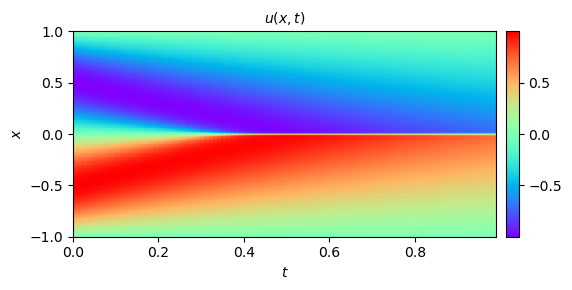

In [78]:
X, T = np.meshgrid(x, t, indexing="ij")
print(X.shape, T.shape)

fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U, interpolation='nearest', cmap='rainbow', 
            extent=[T.min(), T.max(), X.min(), X.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$u(x,t)$', fontsize = 10)

fig.tight_layout()
plt.show()

In [127]:
from pyDOE import lhs         #Latin Hypercube Sampling

## Initial condition at t = 0
left_X_np, left_T_np, left_U_np = X[:, 0], T[:, 0], U[:, 0]
print(">> IC:", left_X_np.shape, left_T_np.shape, left_U_np.shape)

## Boundary condition at x = -1 (x_min)
bottom_X_np, bottom_T_np, bottom_U_np = X[0, :], T[0, :], U[0, :]
print(">> BC:", bottom_X_np.shape, bottom_T_np.shape, bottom_U_np.shape)

## Boundary condition at x = 1 (x_max)
top_X_np, top_T_np, top_U_np = X[-1, :], T[-1, :], U[-1, :]
print(">> BC:", top_X_np.shape, top_T_np.shape, top_U_np.shape)

## Collocation points
n_train = 1000
lb, ub = np.array([x_min, t_min]), np.array([x_max, t_max])
points = lb + (ub - lb)*lhs(2, n_train)
train_X_np, train_T_np = points[:, 0], points[:, 1]
print(">> Train:", train_X_np.shape, train_T_np.shape)

## test points
test_X_np, test_T_np, test_U_np = X.flatten(), T.flatten(), U.flatten()
print(">> Test:", test_X_np.shape, test_T_np.shape, test_U_np.shape)

>> IC: (256,) (256,) (256,)
>> BC: (100,) (100,) (100,)
>> BC: (100,) (100,) (100,)
>> Train: (1000,) (1000,)
>> Test: (25600,) (25600,) (25600,)


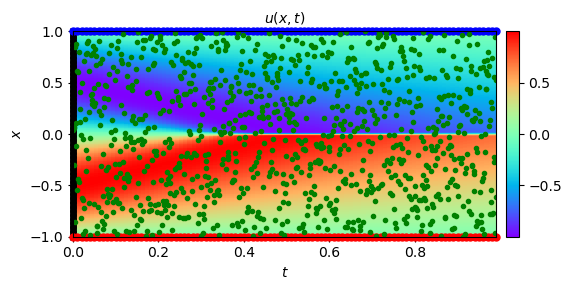

In [102]:
fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U, interpolation='nearest', cmap='rainbow', 
            extent=[T.min(), T.max(), X.min(), X.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
fig.colorbar(h, cax=cax)

ax.plot(left_T_np, left_X_np, 'kx', ms=5, clip_on=False)
ax.plot(bottom_T_np, bottom_X_np, 'ro', ms=5, clip_on=False)
ax.plot(top_T_np, top_X_np, 'bo', ms=5, clip_on=False)
ax.plot(train_T_np, train_X_np, "go", ms=3)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$u(x,t)$', fontsize = 10)

fig.tight_layout()
plt.show()

In [128]:
left_X = torch.tensor(left_X_np).float().to(device)
left_T = torch.tensor(left_T_np).float().to(device)
left_U = torch.tensor(left_U_np).float().to(device)

bottom_X = torch.tensor(bottom_X_np).float().to(device)
bottom_T = torch.tensor(bottom_T_np).float().to(device)
bottom_U = torch.tensor(bottom_U_np).float().to(device)

top_X = torch.tensor(top_X_np).float().to(device)
top_T = torch.tensor(top_T_np).float().to(device)
top_U = torch.tensor(top_U_np).float().to(device)

train_X = torch.tensor(train_X_np).float().to(device)
train_T = torch.tensor(train_T_np).float().to(device)

test_X = torch.tensor(test_X_np).float().to(device)
test_T = torch.tensor(test_T_np).float().to(device)
test_U = torch.tensor(test_U_np).float().to(device)

### Model

In [181]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation, final_activation=None):
        super().__init__()
        self.layer_sizes = layer_sizes
        self.depth = len(layer_sizes) - 1

        layers = []
        for i in range(self.depth - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(activation)
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        if final_activation is not None:
            layers.append(final_activation)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class PINN(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.mlp = MLP(layer_sizes, activation=nn.Tanh())
    
    def forward(self, x, t):
        x = torch.concat([x.unsqueeze(-1), t.unsqueeze(-1)], dim=-1)
        out = self.mlp(x)
        return out.squeeze()

In [182]:
def gradient(y, x):
    return torch.autograd.grad(y, x, torch.ones_like(y),
                               retain_graph=True, create_graph=True)[0]

def residual_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)
    u_t = gradient(u, t)
    u_x = gradient(u, x)
    u_xx = gradient(u_x, x)
    residual = u_t + u*u_x - (0.01/np.pi)*u_xx
    return torch.mean(residual**2)

In [178]:
model = PINN(layer_sizes=[2, 50, 50, 50, 50, 1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.985)

n_epochs = 10000
for epoch in range(1, n_epochs + 1):
    model.train()
    loss_eqn = residual_loss(model, train_X, train_T)
    loss_left = torch.mean((model(left_X, left_T) - left_U)**2)
    loss_bottom = torch.mean((model(bottom_X, bottom_T) - bottom_U)**2)
    loss_top = torch.mean((model(top_X, top_T) - top_U)**2)
    
    loss = loss_eqn + loss_left + loss_bottom + loss_top
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    scheduler.step()
    
    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"train_loss: {loss.item():.2e} "
              f"(eqn: {loss_eqn.item():.2e} left: {loss_left.item():.2e} "
              f"bottom: {loss_bottom.item():.2e} top: {loss_top.item():.2e})")

[ 1000/10000] (lr: 8.60e-04) train_loss: 9.28e-02 (eqn: 3.61e-02 left: 5.48e-02 bottom: 1.38e-03 top: 6.04e-04)
[ 2000/10000] (lr: 7.39e-04) train_loss: 6.03e-02 (eqn: 2.40e-02 left: 3.59e-02 bottom: 2.71e-04 top: 1.48e-04)
[ 3000/10000] (lr: 6.35e-04) train_loss: 4.49e-02 (eqn: 1.54e-02 left: 2.87e-02 bottom: 4.16e-04 top: 4.13e-04)
[ 4000/10000] (lr: 5.46e-04) train_loss: 2.48e-02 (eqn: 1.05e-02 left: 1.41e-02 bottom: 7.80e-05 top: 1.07e-04)
[ 5000/10000] (lr: 4.70e-04) train_loss: 1.49e-02 (eqn: 9.97e-03 left: 4.73e-03 bottom: 1.01e-04 top: 9.83e-05)
[ 6000/10000] (lr: 4.04e-04) train_loss: 5.07e-03 (eqn: 3.18e-03 left: 1.81e-03 bottom: 2.81e-05 top: 5.34e-05)
[ 7000/10000] (lr: 3.47e-04) train_loss: 2.87e-03 (eqn: 1.80e-03 left: 1.02e-03 bottom: 2.05e-05 top: 2.56e-05)
[ 8000/10000] (lr: 2.98e-04) train_loss: 1.97e-03 (eqn: 1.30e-03 left: 6.39e-04 bottom: 1.98e-05 top: 1.17e-05)
[ 9000/10000] (lr: 2.57e-04) train_loss: 1.54e-03 (eqn: 1.08e-03 left: 4.41e-04 bottom: 1.91e-05 top: 9.

In [179]:
model.eval()
with torch.no_grad():
    U_pred = model(test_X, test_T)
    
U_pred_np = U_pred.cpu().detach().numpy().reshape(x_size, t_size)
U_pred_np.shape

(256, 100)

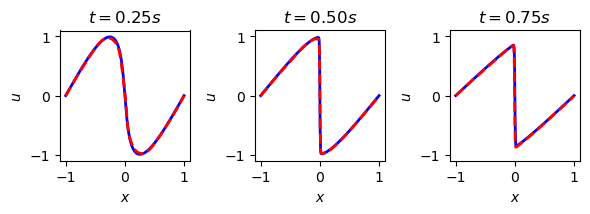

In [183]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(6, 3))
ax1.plot(x, U[:, 25], 'b-', lw=2, label='Exact')
ax1.plot(x, U_pred_np[:, 25], 'r--', lw=2, label='Prediction')
ax1.set_title('$t = 0.25s$')

ax2.plot(x, U[:, 50], 'b-', lw=2, label='Exact')
ax2.plot(x, U_pred_np[:, 50], 'r--', lw=2, label='Prediction')
ax2.set_title('$t = 0.50s$')

ax3.plot(x, U[:, 75], 'b-', lw=2, label='Exact')
ax3.plot(x, U_pred_np[:, 75], 'r--', lw=2, label='Prediction')
ax3.set_title('$t = 0.75s$')


for ax in (ax1, ax2, ax3):
    # ax.legend(fontsize=6)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    
fig.tight_layout()
plt.show()